In [1]:
import logging
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore", category=DeprecationWarning) 

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
#构建corpus
import os
path ="D:/毕业设计/data/news_abstract/"  # 待处理的数据
fileList = os.listdir(path)
docs = [] #文档集合
for i in tqdm(range(len(fileList))):
    file = fileList[i]
    filePath = os.path.join(path, file)
    f = open(filePath, encoding='utf-8')
    content = f.read()
    f.close()
    docs.append(content)
print(len(docs))

  0%|          | 0/139119 [00:00<?, ?it/s]

139119


In [4]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string 
tokenizer = RegexpTokenizer(r'\w+')
def Preprocessing(text):
    # 将文本转成小写
    text = text.lower()
    
    # 删除我们的标点符号
    for c in string.punctuation:
        text = text.replace(c," ")
        
    # 分词
    wordList = tokenizer.tokenize(text)
    
    # 去除停顿词
    filtered = [w for w in wordList if w not in stopwords.words('english')]

#     # stem 
#     ps = PorterStemmer()
#     filtered = [ps.stem(w) for w in filtered]
    
    # 词形还原
    wordnet_lemmatizer = WordNetLemmatizer()
    filtered = [wordnet_lemmatizer.lemmatize(w) for w in filtered ]
    
    # Remove numbers, but not words that contain numbers.
    filtered = [token for token in filtered if not token.isnumeric()]
    
    # Remove words that are only one character.
    filtered = [token for token in filtered if len(token) > 1]
    
    return filtered

for idx in tqdm(range(len(docs))):
    docs[idx] = Preprocessing(docs[idx])
corpus = [" ".join(doc) for doc in docs]
print(corpus[0])

  0%|          | 0/139119 [00:00<?, ?it/s]

recently september worked apple launch applecare theft loss offering provides coverage hardware service accidental damage theft loss well software technical support something believe continues growing need consumer come heel several device program helped launch globally last two year enable carrier cable partner offer access applecare service represents apple newest comprehensive option family device protection plan available store online select resellers like best buy


In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(use_idf=True) # 构建tf-idf向量
X_tfidf = vectorizer_tfidf.fit_transform(corpus)

In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

print("Performing dimensionality reduction using LSA")
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD(1000)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_tfidf_lsa = lsa.fit_transform(X_tfidf)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

print(X_tfidf_lsa.shape)

Performing dimensionality reduction using LSA
Explained variance of the SVD step: 51%
(139119, 1000)


In [7]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
# 降维，minbatch? 2*2 = 4种
minikm_X_tfidf_lsa = MiniBatchKMeans(n_clusters=10, init='k-means++', n_init=1, init_size=1000, batch_size=1000, verbose=False)
minikm_X_tfidf_lsa.fit(X_tfidf_lsa)

minikm_X_tfidf = MiniBatchKMeans(n_clusters=10, init='k-means++', n_init=1, init_size=1000, batch_size=1000, verbose=False)
minikm_X_tfidf.fit(X_tfidf)

km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1, verbose=False)
km_X_tfidf_lsa = km.fit(X_tfidf_lsa)

km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1, verbose=False)
km_X_tfidf = km.fit(X_tfidf)

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "


In [8]:
# minikm-tfidf-lsa
print("Top terms per cluster:")
original_space_centroids = svd.inverse_transform(minikm_X_tfidf_lsa.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer_tfidf.get_feature_names()

for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: aws service data cloud please new amazon make use like
Cluster 1: deal amazon price prime best offering time today day sale
Cluster 2: stock share market quarter nasdaq earnings amd company inc investor
Cluster 3: please blocker proceeding blocked frequently happening forum happen ensure feedback
Cluster 4: apple iphone new app pro watch io ipad store feature
Cluster 5: newsletter news intersect coindesk inner deeply crypto commentary miss sunday
Cluster 6: sec gov declare downloading traffic practice information data including best
Cluster 7: tv show amazon series apple alexa streaming new film video
Cluster 8: purchase rating price average traded estimated stock portfolio holding due
Cluster 9: amazon company said bezos year business new space billion million


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
#这里要重新处理一下，没有降维过后的数据是稀疏的，无法进行后两个指标的评价
from sklearn import metrics


X = X_tfidf_lsa
for index, method in enumerate([minikm_X_tfidf_lsa,km_X_tfidf_lsa]):
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, method.labels_, metric='euclidean'))
    print(" Davies-Bouldin Index: %0.3f"
          % metrics.davies_bouldin_score(X, method.labels_))

   
    print("----------------------------------------------------------------")


Silhouette Coefficient: 0.059
 Davies-Bouldin Index: 5.640
----------------------------------------------------------------
Silhouette Coefficient: 0.044
 Davies-Bouldin Index: 5.792
----------------------------------------------------------------


In [12]:
# minikm-tfidf-lsa
print("Top terms per cluster:")
original_space_centroids = svd.inverse_transform(minikm_X_tfidf_lsa.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer_tfidf.get_feature_names()

for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()


Top terms per cluster:
Cluster 0: deal amazon price prime best offering today shipped time day
Cluster 1: app apple io store apps developer user update beta new
Cluster 2: please blocker proceeding blocked frequently happening forum ensure happen javascript
Cluster 3: purchase stock price traded portfolio average estimated holding due impact
Cluster 4: new amazon one make get like game please tv series
Cluster 5: apple iphone new pro ipad watch macbook mac model year
Cluster 6: stock share market quarter billion company year earnings nasdaq revenue
Cluster 7: newsletter rating news daily intersect coindesk inner deeply crypto commentary
Cluster 8: sec gov declare downloading traffic practice information data including best
Cluster 9: amazon company said service bezos business aws new customer year


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
result = list(minikm_X_tfidf.predict(X_tfidf))
print ('Cluster distribution:')
print (dict([(i, result.count(i)) for i in result]))
print(-minikm_X_tfidf.score(X_tfidf))

Cluster distribution:
{9: 7143, 4: 510, 0: 127, 3: 1250, 2: 137, 8: 94, 7: 176, 1: 137, 5: 220, 6: 206}
6949.1970685141


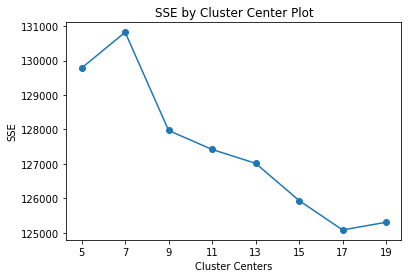

In [13]:
import matplotlib.pyplot as plt
def find_optimal_clusters(data, max_k):
    iters = range(5, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init="k-means++", init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X_tfidf, 20)

In [8]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in tqdm(range(len(docs))):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)


2022-04-25 18:45:48,165 : INFO : collecting all words and their counts
2022-04-25 18:45:48,178 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2022-04-25 18:45:49,220 : INFO : PROGRESS: at sentence #10000, processed 526415 words and 338228 word types
2022-04-25 18:45:50,292 : INFO : PROGRESS: at sentence #20000, processed 1049374 words and 585196 word types
2022-04-25 18:45:51,325 : INFO : PROGRESS: at sentence #30000, processed 1576489 words and 800600 word types
2022-04-25 18:45:52,461 : INFO : PROGRESS: at sentence #40000, processed 2102844 words and 996469 word types
2022-04-25 18:45:53,738 : INFO : PROGRESS: at sentence #50000, processed 2630374 words and 1176505 word types
2022-04-25 18:45:54,929 : INFO : PROGRESS: at sentence #60000, processed 3156358 words and 1347368 word types
2022-04-25 18:45:56,451 : INFO : PROGRESS: at sentence #70000, processed 3681923 words and 1505667 word types
2022-04-25 18:45:57,565 : INFO : PROGRESS: at sentence #80000, process

  0%|          | 0/139119 [00:00<?, ?it/s]

In [9]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

2022-04-25 18:46:42,955 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-04-25 18:46:44,348 : INFO : adding document #10000 to Dictionary(35922 unique tokens: ['access', 'accidental', 'accidental_damage', 'apple', 'applecare']...)
2022-04-25 18:46:45,285 : INFO : adding document #20000 to Dictionary(47341 unique tokens: ['access', 'accidental', 'accidental_damage', 'apple', 'applecare']...)
2022-04-25 18:46:46,158 : INFO : adding document #30000 to Dictionary(55553 unique tokens: ['access', 'accidental', 'accidental_damage', 'apple', 'applecare']...)
2022-04-25 18:46:47,037 : INFO : adding document #40000 to Dictionary(62351 unique tokens: ['access', 'accidental', 'accidental_damage', 'apple', 'applecare']...)
2022-04-25 18:46:47,897 : INFO : adding document #50000 to Dictionary(68020 unique tokens: ['access', 'accidental', 'accidental_damage', 'apple', 'applecare']...)
2022-04-25 18:46:48,774 : INFO : adding document #60000 to Dictionary(73418 unique tokens: ['acces

In [10]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [22]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 22484
Number of documents: 139119


In [10]:
#无用了
import gensim
import time
# Set training parameters.
num_topics = 4
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

os.environ.update({'MALLET_HOME': r'D:/毕业设计/dependencies/mallet-2.0.8'})
mallet_path = 'D:/毕业设计/dependencies/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word = dictionary)

2022-04-23 10:11:56,636 : INFO : serializing temporary corpus to C:\Users\huiye\AppData\Local\Temp\9abc19_corpus.txt
2022-04-23 10:11:57,134 : INFO : converting temporary corpus to MALLET format with D:/毕业设计/dependencies/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\huiye\AppData\Local\Temp\9abc19_corpus.txt --output C:\Users\huiye\AppData\Local\Temp\9abc19_corpus.mallet
2022-04-23 10:12:01,578 : INFO : training MALLET LDA with D:/毕业设计/dependencies/mallet-2.0.8/bin/mallet train-topics --input C:\Users\huiye\AppData\Local\Temp\9abc19_corpus.mallet --num-topics 4  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state C:\Users\huiye\AppData\Local\Temp\9abc19_state.mallet.gz --output-doc-topics C:\Users\huiye\AppData\Local\Temp\9abc19_doctopics.txt --output-topic-keys C:\Users\huiye\AppData\Local\Temp\9abc19_topickeys.txt --num-iterations 1000 --inferencer-filename C:\Users\huiye\AppData\Local\Temp\9abc

In [ ]:
import gensim
from gensim.models import CoherenceModel
num_topics = 4
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.
os.environ.update({'MALLET_HOME': r'D:/毕业设计/dependencies/mallet-2.0.8'})
mallet_path = 'D:/毕业设计/dependencies/mallet-2.0.8/bin/mallet' # update this path
#迭代的方法求最优的主题数量
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=4, limit=30, step=2)

2022-04-25 19:00:51,199 : INFO : serializing temporary corpus to C:\Users\huiye\AppData\Local\Temp\e69ab7_corpus.txt
2022-04-25 19:00:58,218 : INFO : converting temporary corpus to MALLET format with D:/毕业设计/dependencies/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\huiye\AppData\Local\Temp\e69ab7_corpus.txt --output C:\Users\huiye\AppData\Local\Temp\e69ab7_corpus.mallet
2022-04-25 19:01:16,459 : INFO : training MALLET LDA with D:/毕业设计/dependencies/mallet-2.0.8/bin/mallet train-topics --input C:\Users\huiye\AppData\Local\Temp\e69ab7_corpus.mallet --num-topics 4  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state C:\Users\huiye\AppData\Local\Temp\e69ab7_state.mallet.gz --output-doc-topics C:\Users\huiye\AppData\Local\Temp\e69ab7_doctopics.txt --output-topic-keys C:\Users\huiye\AppData\Local\Temp\e69ab7_topickeys.txt --num-iterations 1000 --inferencer-filename C:\Users\huiye\AppData\Local\Temp\e69a

2022-04-25 19:28:53,424 : INFO : training MALLET LDA with D:/毕业设计/dependencies/mallet-2.0.8/bin/mallet train-topics --input C:\Users\huiye\AppData\Local\Temp\6be460_corpus.mallet --num-topics 14  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state C:\Users\huiye\AppData\Local\Temp\6be460_state.mallet.gz --output-doc-topics C:\Users\huiye\AppData\Local\Temp\6be460_doctopics.txt --output-topic-keys C:\Users\huiye\AppData\Local\Temp\6be460_topickeys.txt --num-iterations 1000 --inferencer-filename C:\Users\huiye\AppData\Local\Temp\6be460_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 0
2022-04-25 19:33:38,906 : INFO : loading assigned topics from C:\Users\huiye\AppData\Local\Temp\6be460_state.mallet.gz
2022-04-25 19:33:58,989 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2022-04-25 19:34:32,802 : INFO : 7 accumulators retrieved from output queue
2022-04-25 19:34:32,865 : INFO : accumulate

[0.4974949980606632, 0.5073471509466166, 0.550571053964901, 0.6050765517322579, 0.6121855726104608, 0.5802254489659047, 0.597558919486616, 0.6405275092466353, 0.6075123605162159, 0.650421151768174, 0.6476047200984949, 0.6388919373577777, 0.6195702750971473]


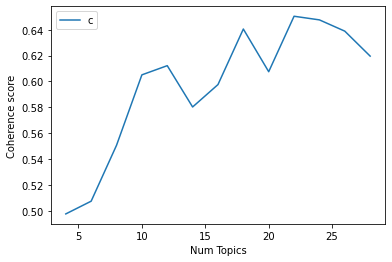

In [18]:
#绘制coherence_values—n_topics图像
import matplotlib.pyplot as plt
print(coherence_values)
limit=30; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
#生成 html 图像
import pyLDAvis.gensim_models
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
#将两个模型进行住转化
vis_model = malletmodel2ldamodel(model_list[9])
vis = pyLDAvis.gensim_models.prepare(vis_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_mallet.html')

2022-04-25 20:34:36,580 : INFO : NumExpr defaulting to 8 threads.
2022-04-25 20:34:39,092 : INFO : using serial LDA version on this node
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [21]:
# 反过来打标签
import pandas as pd
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output 
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    # ldamodel[doc] => get topic probability distribution for a document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True) # 依据概率分布进行排序
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num) # probability pairs for the most relevant words generated by the topic.
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

optimal_model = model_list[9]
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


2022-04-25 20:37:28,885 : INFO : serializing temporary corpus to C:\Users\huiye\AppData\Local\Temp\34285_corpus.txt
2022-04-25 20:37:35,953 : INFO : converting temporary corpus to MALLET format with D:/毕业设计/dependencies/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\huiye\AppData\Local\Temp\34285_corpus.txt --output C:\Users\huiye\AppData\Local\Temp\34285_corpus.mallet.infer --use-pipe-from C:\Users\huiye\AppData\Local\Temp\34285_corpus.mallet
2022-04-25 20:38:07,325 : INFO : inferring topics with MALLET LDA 'D:/毕业设计/dependencies/mallet-2.0.8/bin/mallet infer-topics --input C:\Users\huiye\AppData\Local\Temp\34285_corpus.mallet.infer --inferencer C:\Users\huiye\AppData\Local\Temp\34285_inferencer.mallet --output-doc-topics C:\Users\huiye\AppData\Local\Temp\34285_doctopics.txt.infer --num-iterations 100 --doc-topics-threshold 0.0 --random-seed 0'


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.0924,"pro, iphone, model, ipad, inch, macbook, mac, ...","[recently, september, worked, apple, launch, a..."
1,1,18.0,0.6442,"including, sec, data, information, gov, practi...","[please, declare, traffic, updating, user, age..."
2,2,9.0,0.3047,"space, bezos, year, ceo, jeff, company, blue, ...","[shortly, launch, meme, began, trend, across, ..."
3,3,17.0,0.4926,"apple, app, store, apps, game, content, google...","[personal, connection, like, home, run, anti, ..."
4,4,6.0,0.2011,"pro, iphone, model, ipad, inch, macbook, mac, ...","[korean, publication, elec, claim, apple, thre..."
5,5,1.0,0.1198,"dec, ago, hour, est, pm, adobe, security, site...","[low, around, 25f, wind, mph, updated, decembe..."
6,6,0.0,0.3404,"december, week, tech, point, stock, high, time...","[opt, time, hate, spam, tradersville, net, inv..."
7,7,7.0,0.1941,"apple, iphone, year, company, cook, china, rep...","[wireless, charging, pad, apple, announced, ip..."
8,8,20.0,0.2714,"share, stock, year, billion, quarter, company,...","[hong, kong, china, american, multinational, t..."
9,9,13.0,0.2534,"company, tech, facebook, state, case, group, c...","[new, orleans, sept, globe, newswire, kahn, sw..."


In [1]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet


NameError: name 'pd' is not defined